In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [30]:
import SelectionMask as sm

In [31]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Defines transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

# Download and transform
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [32]:
images, labels = next(iter(train_loader))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, mask):
        super(SimpleCNN, self).__init__()
        self.mask = mask
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.mask(x)
        
        # initiates with size = (1, 28, 28)
        x = self.pool(F.relu(self.conv1(x))) # (32, 14, 14)
        x = self.pool(F.relu(self.conv2(x))) # (64, 7, 7)
        x = self.pool(F.relu(self.conv3(x))) # (128, 3, 3)
        x = self.dropout1(x)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x
selection_mask = sm.SelectionMask(shape=(1,28,28))
model = SimpleCNN(selection_mask)

In [ ]:
import torch.optim as optim

criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [36]:
def plot_mask(selection_mask):    
    with torch.no_grad():
        mask_sigmoid = torch.sigmoid(selection_mask.mask.cpu())
        mask_binary = (mask_sigmoid > 0.5).float()
    
    # Remove dimensões extras se necessário
    if mask_binary.dim() == 3:
        mask_binary = mask_binary.squeeze(0)
    
    plt.imshow(mask_binary, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

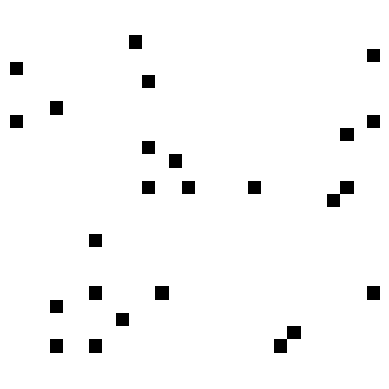

Epoch 1, Loss: 0.6655996475916809


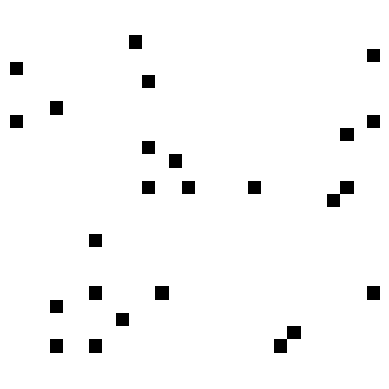

Epoch 2, Loss: 0.19591870518730903


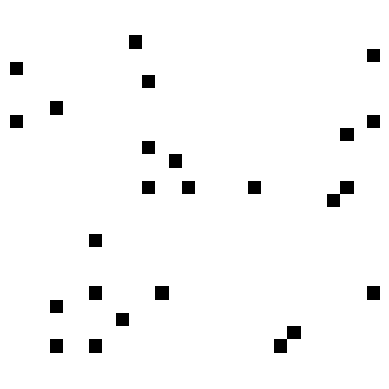

Epoch 3, Loss: 0.17874970333948573


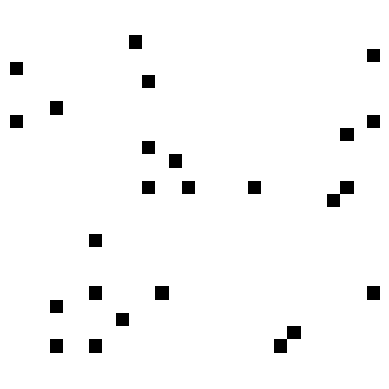

Epoch 4, Loss: 0.17700171086198485


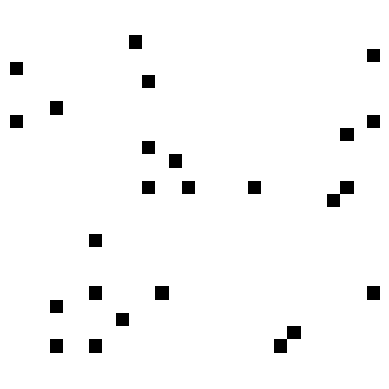

Epoch 5, Loss: 0.17992225694440322


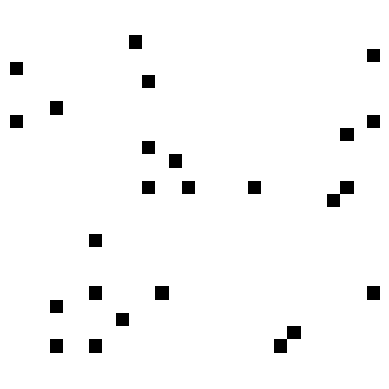

Epoch 6, Loss: 0.18829117516782493


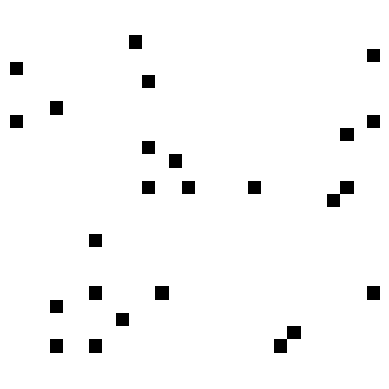

Epoch 7, Loss: 0.19808036954735897


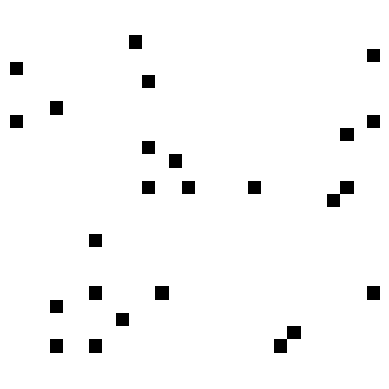

Epoch 8, Loss: 0.21093366102877456


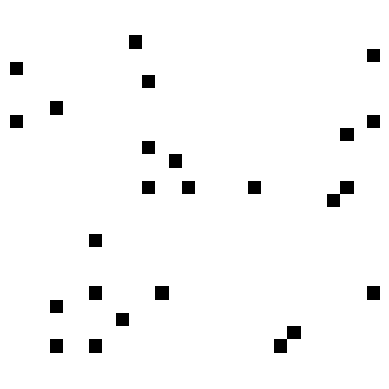

Epoch 9, Loss: 0.22556223856932572


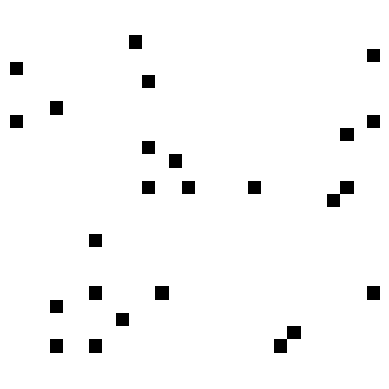

Epoch 10, Loss: 0.24386230643306459


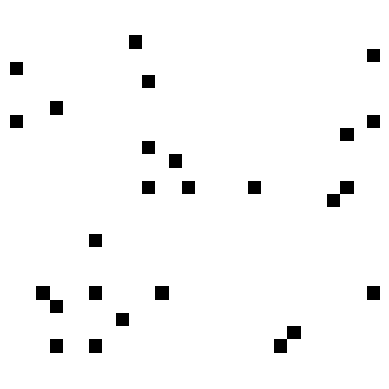

Epoch 11, Loss: 0.26225238692150443


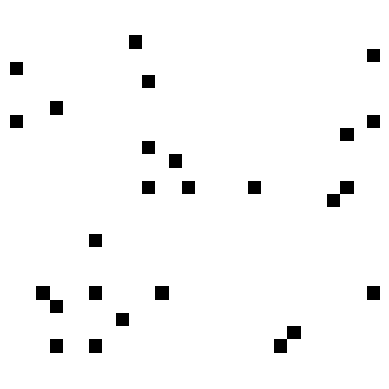

Epoch 12, Loss: 0.2864135975903794


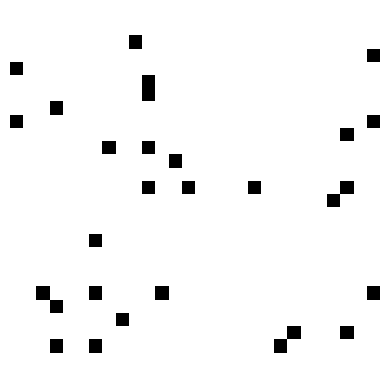

Epoch 13, Loss: 0.3096738866905668


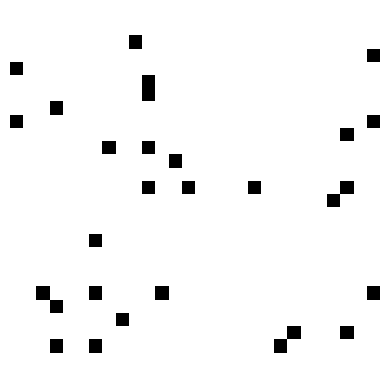

Epoch 14, Loss: 0.33732696220691777


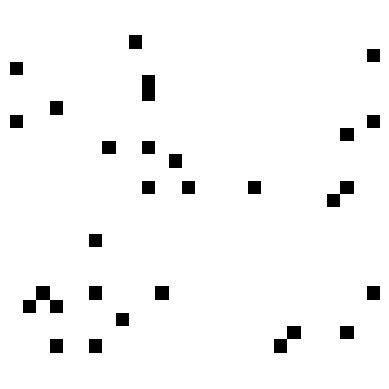

Epoch 15, Loss: 0.3660291447314118


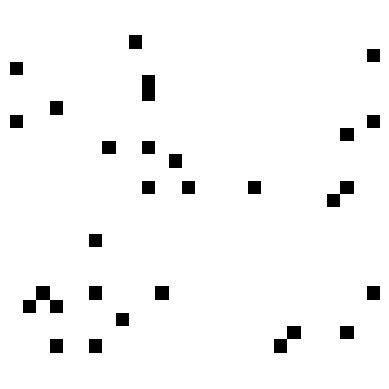

Epoch 16, Loss: 0.40110343465927056


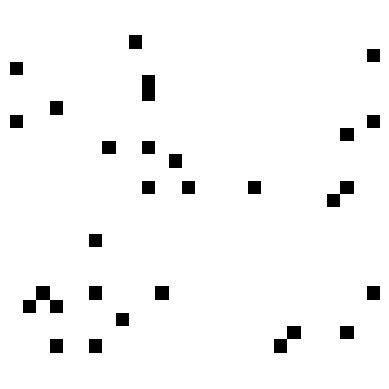

Epoch 17, Loss: 0.43618472416136567


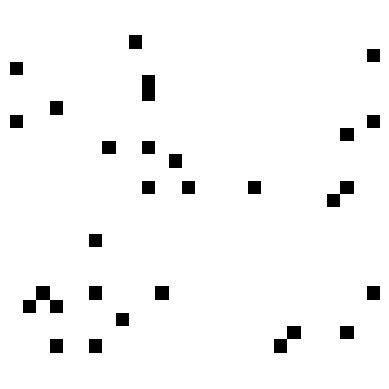

Epoch 18, Loss: 0.47818242998392596


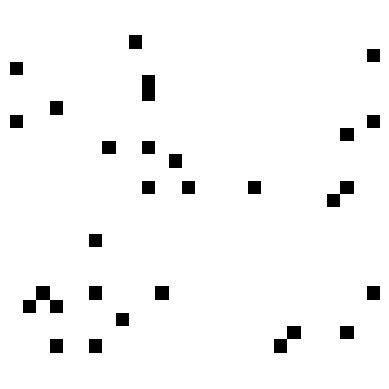

Epoch 19, Loss: 0.5221686333354348


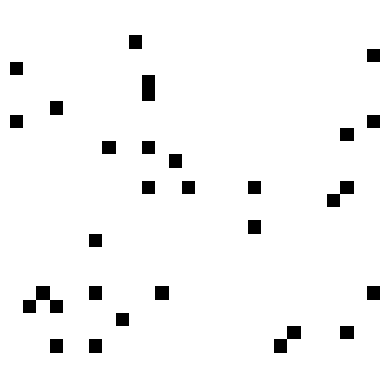

Epoch 20, Loss: 0.5723277254780726


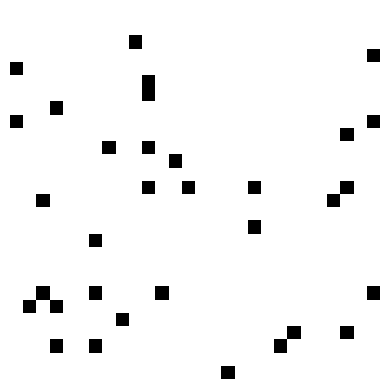

Epoch 21, Loss: 0.6260512929989585


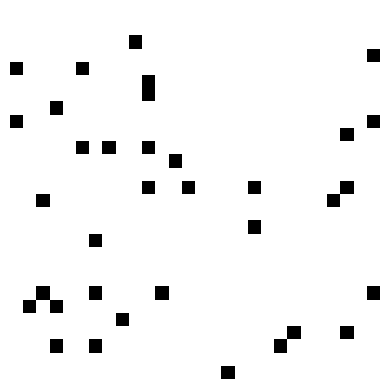

Epoch 22, Loss: 0.6856078417824784


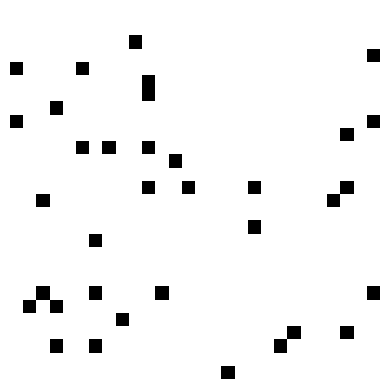

Epoch 23, Loss: 0.7499680907995716


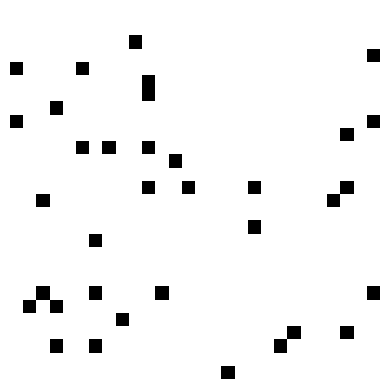

Epoch 24, Loss: 0.8212654470507779


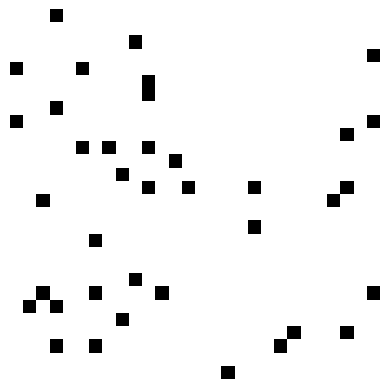

Epoch 25, Loss: 0.8996975777118699


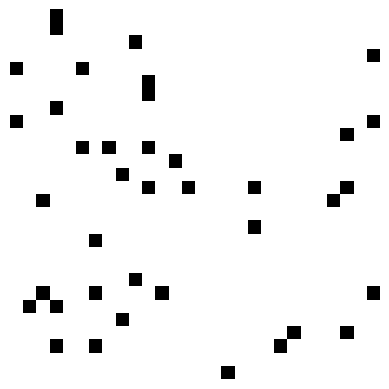

Epoch 26, Loss: 0.9852692702177491


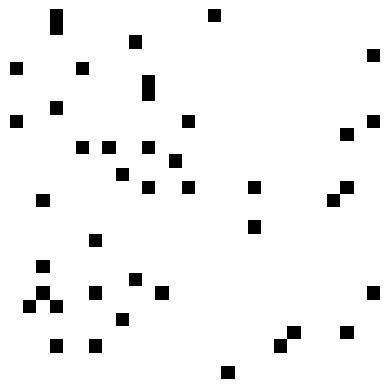

Epoch 27, Loss: 1.0783975018875431


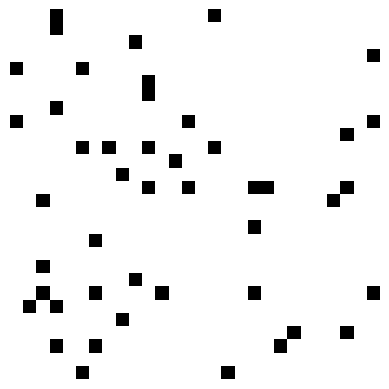

Epoch 28, Loss: 1.1793931484984945


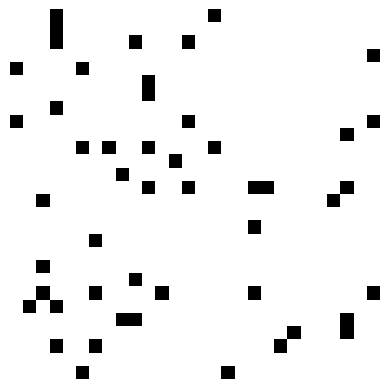

Epoch 29, Loss: 1.2914562015645286


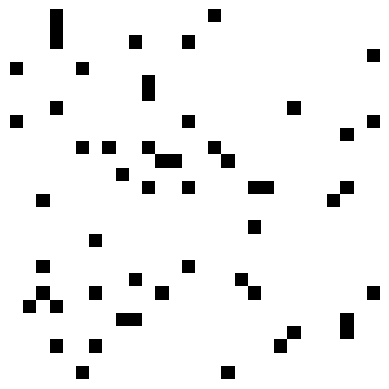

Epoch 30, Loss: 1.4105086054629101


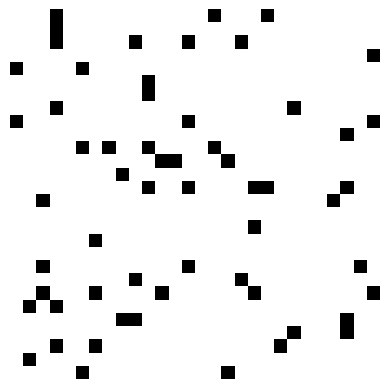

Epoch 31, Loss: 1.5403218828538843


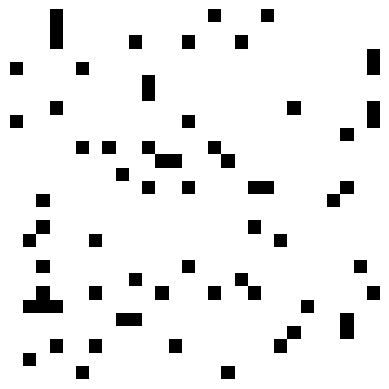

Epoch 32, Loss: 1.6828195968670632


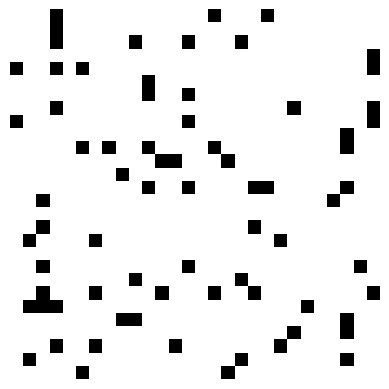

Epoch 33, Loss: 1.834339454738316


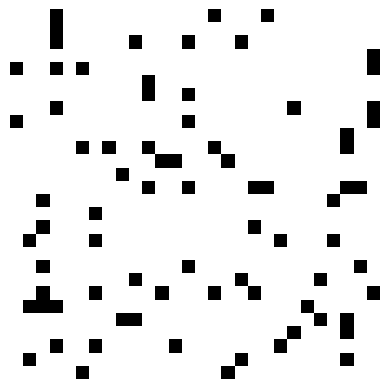

Epoch 34, Loss: 1.9979160400087645


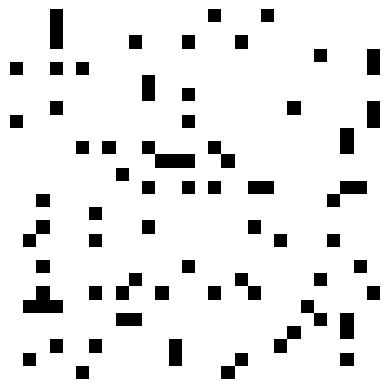

Epoch 35, Loss: 2.1764279939472546


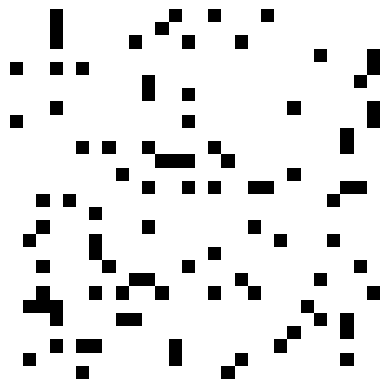

Epoch 36, Loss: 2.364763745875247


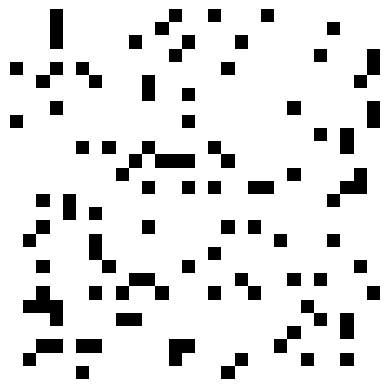

Epoch 37, Loss: 2.56598431240521


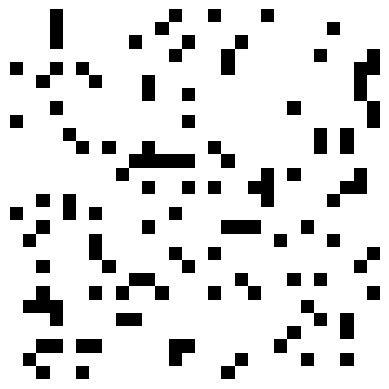

Epoch 38, Loss: 2.7805888962898173


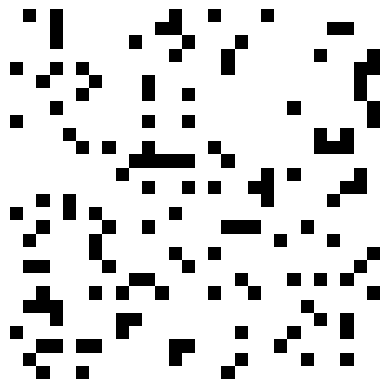

Epoch 39, Loss: 3.004103679392638


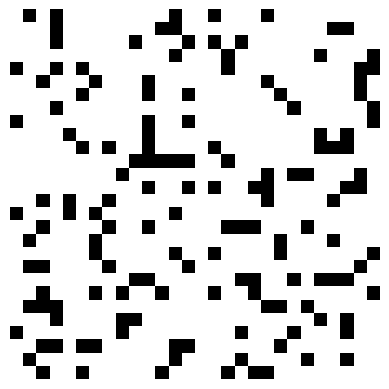

Epoch 40, Loss: 3.2373394589942657


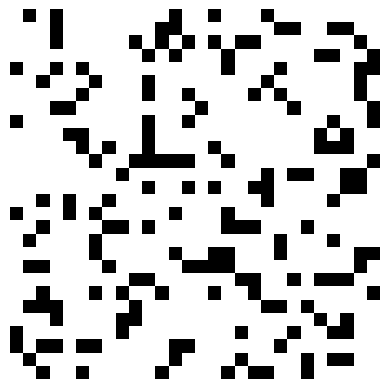

Epoch 41, Loss: 3.4796444480098896


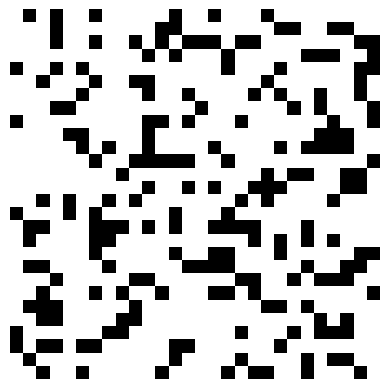

Epoch 42, Loss: 3.7286070102313436


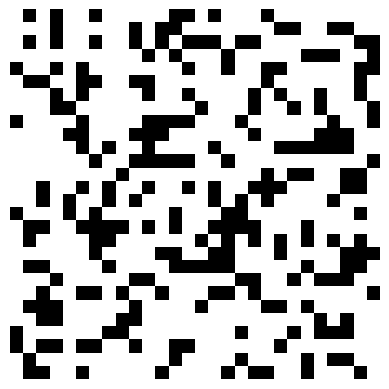

Epoch 43, Loss: 3.9746311414978908


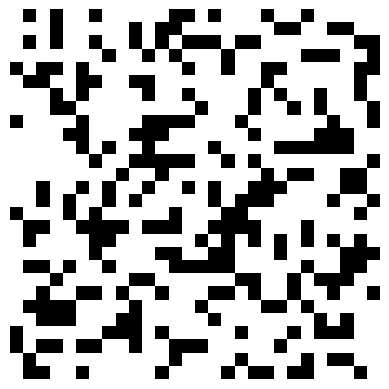

Epoch 44, Loss: 4.218198622213498


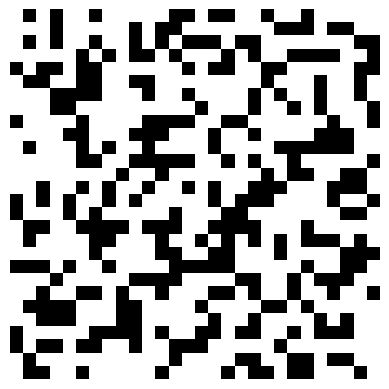

Epoch 45, Loss: 4.456100379480228


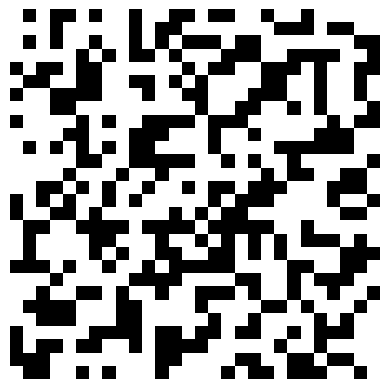

Epoch 46, Loss: 4.682890802558297


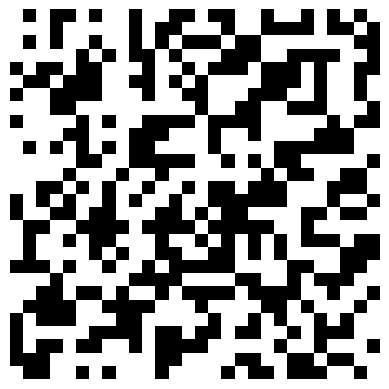

Epoch 47, Loss: 4.88854960642898


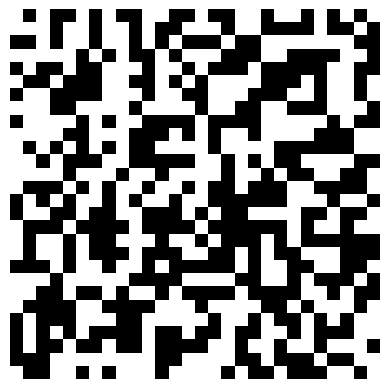

Epoch 48, Loss: 5.067307667945748


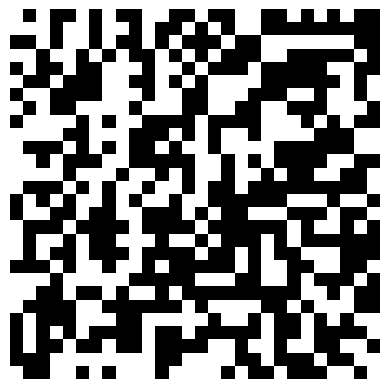

Epoch 49, Loss: 5.216321499871293


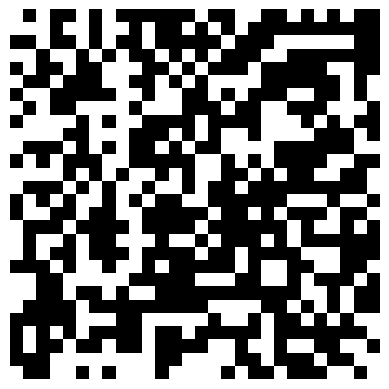

Epoch 50, Loss: 5.328518080558858
Training complete!
Checkpoints saved in 'checkpoints' directory


In [ ]:
import torch
import os

# Criar diretório para checkpoints se não existir
os.makedirs('checkpoints', exist_ok=True)

epochs = 50
s = 0.1
for epoch in range(epochs):
    running_loss = 0.0
    s = s * 1.1
    
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) + (s * sm.mask_l1_loss(selection_mask))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
#     # Salvar checkpoint
#     checkpoint = {
#         'epoch': epoch + 1,
#         'model_state_dict': model.state_dict(),
#         'selection_mask_state_dict': selection_mask.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': avg_loss,
#         's': s
#     }
#     torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')

# # Salvar modelo final
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'selection_mask_state_dict': selection_mask.state_dict(),
# }, 'checkpoints/final_model.pth')

# print("Training complete!")
# print("Checkpoints saved in 'checkpoints' directory")

In [42]:
def test_model(test_loader, selection_mask, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(selection_mask(images))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# for i in range(epochs):
#     checkpoint = torch.load(f'checkpoints/checkpoint_epoch_{i + 1}.pth')
#     model.load_state_dict(checkpoint['model_state_dict'])
#     selection_mask.load_state_dict(checkpoint['selection_mask_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch']
#     s = checkpoint['s']
#     accuracy = test_model(test_loader, selection_mask, model)
#     print(f"epoch: {start_epoch}\ns: {s}\naccuracy: {accuracy}\n\n")